In [1]:
import pandas as pd

In [2]:
pg = pd.read_csv('Prochlorococcus/cluster_assignments.csv')
pg.head()

,Unnamed: 0,Tree 0,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Consensus Cluster,Item Consensus Score
0,EV12_0001,3,2,1,4,0,3,0,47,4,0,18,0.155083
1,EV12_0002,16,9,12,32,13,13,36,38,24,21,5363,0.065455
2,EV12_0003,1130,831,168,451,446,621,346,1137,983,805,1914,1.000000
3,EV12_0004,736,1422,1414,866,1427,1521,1177,1236,1497,1016,1365,1.000000
4,EV12_0005,1723,1758,1483,1618,1312,1486,1607,1740,1741,1659,4771,1.000000


In [8]:
clusterout = pd.DataFrame({
    'Strain': [i.split('_')[0] for i in pg.iloc[:,0]],
    'Gene': list(pg.iloc[:,0]),
    'Cluster': list(pg['Consensus Cluster'])
})
clusterout.head()

,Strain,Gene,Cluster
0,EV12,EV12_0001,18
1,EV12,EV12_0002,5363
2,EV12,EV12_0003,1914
3,EV12,EV12_0004,1365
4,EV12,EV12_0005,4771


In [9]:
def cluster_to_wide(LongTable, outfile):
    ncluster = len(set(LongTable.Cluster))
    mydict = {strain:['' for i in range(0,ncluster)] for strain in list(set(LongTable.Strain))}

    WideTable = pd.DataFrame(mydict,index = list(set(LongTable.Cluster)), columns = list(set(LongTable.Strain)))

    for i in range(0,LongTable.shape[0]):
        c = LongTable.Cluster[i]
        s = LongTable.Strain[i]
        g = LongTable.Gene[i]

        if  WideTable[s][c] == '':
            WideTable[s][c]=g
        else:
             WideTable[s][c] =  WideTable[s][c]+'|'+g

    WideTable.to_csv(outfile)
    
cluster_to_wide(clusterout, 'Prochlorococcus/Prochlorococcus_wide.csv')

In [10]:
# Plotting imports# Plott 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

sns.set_style('white')

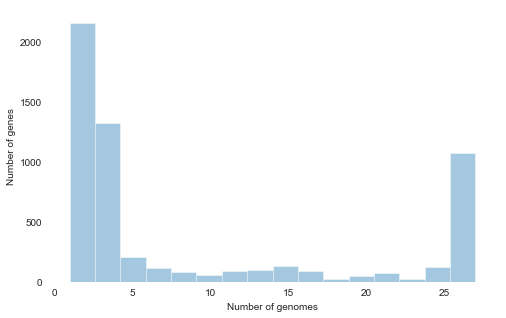

In [11]:
def pg_hist(infile,outfig):
    df = pd.read_csv(infile,index_col = 0)
    df.replace(np.nan, 0, regex=True, inplace=True)
    df.replace('.{2,100}', 1, regex=True, inplace=True)
    
    fig = plt.figure(frameon = False)
    fig.set_size_inches(8,5)
    
    sns.distplot(df.sum(axis=1),kde=False)
    plt.xlabel('Number of genomes')
    plt.ylabel('Number of genes')

    sns.despine(left=True,
                bottom=True)
    plt.savefig(outfig)
    
pg_hist('Prochlorococcus/Prochlorococcus_wide.csv','Prochlorococcus/Prochlorococcus_hist.png')

D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


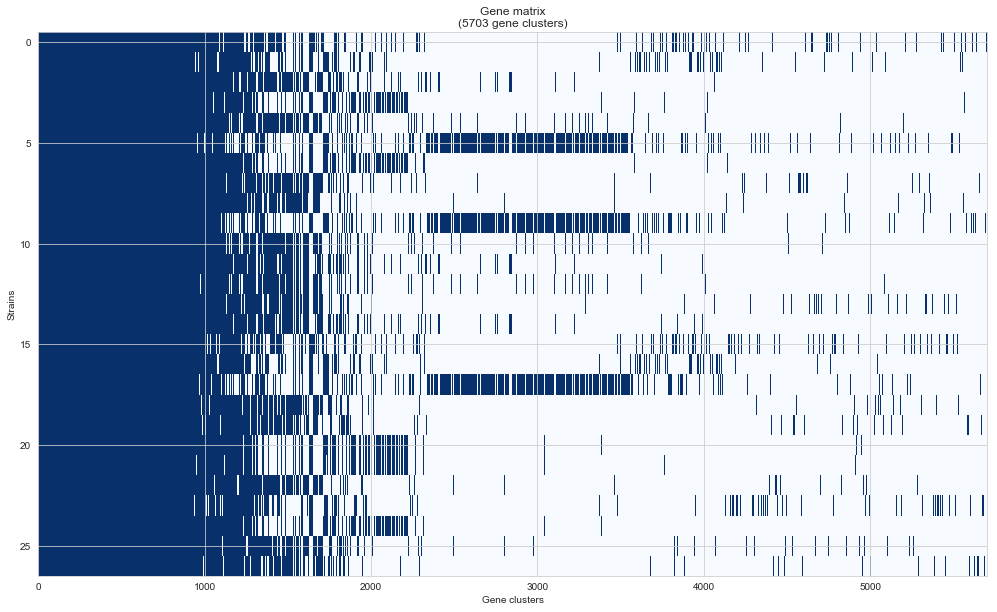

In [12]:
def pg_heatmap(infile,outfig):
    df = pd.read_csv(infile,index_col = 0)
    df.replace(np.nan, 0, regex=True, inplace=True)
    df.replace('.{2,100}', 1, regex=True, inplace=True)
    idx = df.sum(axis=1).sort_values(ascending=False).index
    df_sorted = df.ix[idx]

    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(17, 10))

        plt.imshow(df_sorted.T, cmap=plt.cm.Blues,
                   vmin=0, vmax=1,
                   aspect='auto',
                   interpolation='none',
                    )
        plt.xlabel('Gene clusters')
        plt.ylabel('Strains')
        plt.title('Gene matrix\n(%d gene clusters)'%df.shape[0])
        plt.savefig(outfig)
        
pg_heatmap('Prochlorococcus/Prochlorococcus_wide.csv','Prochlorococcus/Prochlorococcus_heatmap.png')

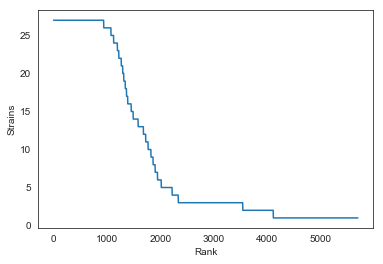

In [25]:
thisdf = pd.read_csv('Prochlorococcus/Prochlorococcus_wide.csv')
thisdf.replace(np.nan, 0, regex=True, inplace=True)
thisdf.replace('.{2,100}', 1, regex=True, inplace=True)
vals = thisdf.iloc[:,1:].sum(axis=1).sort_values(ascending=False)
rankdf = pd.DataFrame({'Rank':range(0,len(vals)),
                      'Strains':vals})
sns.lineplot(data=rankdf, x='Rank',y='Strains')
plt.savefig('Prochlorococcus/Prochlorococcus_clusterrank.svg')

In [22]:
cluster_scores = pd.read_csv('Prochlorococcus/cluster_consensus_scores.csv')
cluster_scores.head()

,Cluster,Score
0,0,1.000000
1,1,1.000000
2,2,0.348889
3,3,1.000000
4,4,0.148889


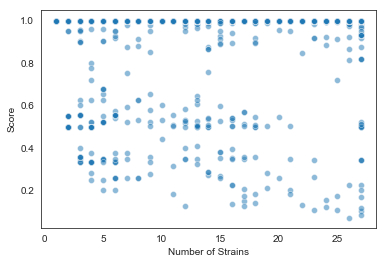

In [24]:
cluster_scores['Number of Strains'] = thisdf.iloc[:,1:].sum(axis=1)
sns.scatterplot(data = cluster_scores, x='Number of Strains', y='Score', alpha=0.5)
plt.savefig('Prochlorococcus/Prochlorococcus_scores.svg')

In [26]:
def select_rand(df,n):
    mycols = np.random.choice(df.columns[1:],n,replace=False)
    sums = df.loc[:,mycols].sum(axis=1)
    corenum = sum([i>n*0.95 for i in sums])
    pannum = sum([i>0 for i in sums])
    return(corenum, pannum)
def make_corepan(infile,outfile):
    df = pd.read_csv(infile,index_col = 0)
    df.replace(np.nan, 0, regex=True, inplace=True)
    df.replace('.{2,100}', 1, regex=True, inplace=True)

    nrange = [int(i) for i in np.linspace(1,df.shape[1]-1,10)]
    niter = 30

    corenums = [0 for i in range(0,len(nrange)*niter)]
    pannums = [0 for i in range(0,len(nrange)*niter)]
    nstrains = [0 for i in range(0,len(nrange)*niter)]

    k=0
    for n in nrange:
        for i in range(0,niter):
            c, p = select_rand(df,n)
            corenums[k]=c
            pannums[k]=p
            nstrains[k]=n
            k+=1
    types = ['core' for i in range(len(corenums))]+['pan' for i in range(len(corenums))]    
    plotdict = {'Strains':nstrains+nstrains,
               'Type':types,
               'Genes':corenums+pannums}

    plotdf = pd.DataFrame(plotdict)
    outcsv = os.path.splitext(outfile)[0]+'.csv'
    plotdf.to_csv(outcsv,index=False)
    sns.lineplot(data=plotdf,x='Strains',y='Genes',hue='Type')
    plt.savefig(outfile)
    plt.close()
    
make_corepan('Prochlorococcus/Prochlorococcus_wide.csv', 'Prochlorococcus/Corepan.svg')

In [27]:
sum(cluster_scores['Number of Strains']==27)

939

In [28]:
cluster_scores.shape

(5703, 3)